In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV

from dataset.get_data import get_dataloaders
from model.tab_dae import DenoisingAutoencoder

import warnings

warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("dataset/MNIST/train.csv.zip")
test = pd.read_csv("dataset/MNIST/test.csv.zip")

In [3]:
train.shape

(42000, 785)

In [4]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
train.columns = list(range(0,785)) # 0th index is always represents the label, rest is pixle values
test.columns = list(range(1,785)) #since test data doesnot contain label this should be `range(1,784)

Let's define our train and validation datasets, first I need to define `X` and `y` from the train data

In [6]:
X = train[list(range(1,785))]
y = train[0]

Since MNIST dataset pixel value range is 0-255 I want to normalize it 0-1 range. Since this is pixele value, I can simply devide all values by `255`

In [7]:
X = X / 255

In [16]:
# Split the data into train and test sets
train_data, test_data = train_test_split(train, test_size=0.2)

train_data,test_data,train_labels,test_labels = train_data.loc[:,1:], test_data.loc[:,1:], train_data.loc[:,0], test_data.loc[:,0]

# Convert the data to a PyTorch tensor
train_data = torch.tensor(train_data.values/255).float()
test_data = torch.tensor(test_data.values/255).float()

# Define the model, optimizer, and loss function
input_dim = X.shape[1]
encoding_dim = 10
hidden_dims = [256, 128, 64, 32, 16]
model = DenoisingAutoencoder(input_dim, hidden_dims, encoding_dim)
optimizer = optim.Adam(model.parameters(),lr=1e-2)
loss_fn = nn.MSELoss()

# Train the model
batch_size = 10000
num_epochs = 10
for epoch in range(num_epochs):
    # Iterate over the training data in batches
    for i in range(0, len(train_data), batch_size):
        inputs = train_data[i:i+batch_size]
        # Forward pass
        output = model(inputs, add_noise=True)
        loss = loss_fn(output, inputs)
        
        # Backward pass and optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Evaluate the model on the test set
    test_loss = 0
    for i in range(0, len(test_data), batch_size):
        inputs = test_data[i:i+batch_size]
        output = model(inputs, add_noise=False)
        test_loss += loss_fn(output, inputs).item()
    test_loss /= len(test_data)
    print(f'Test loss: {test_loss:.5f}')

Test loss: 0.00003
Test loss: 0.00003
Test loss: 0.00003
Test loss: 0.00003
Test loss: 0.00003
Test loss: 0.00002
Test loss: 0.00002
Test loss: 0.00002
Test loss: 0.00002
Test loss: 0.00002


In [17]:
model

DenoisingAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=64, out_features=32, bias=True)
    (13): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.2, inplace=False)
    (16): Linear(in_features=32, out_features=16, bias=True)
    (17): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True,

In [18]:
latent_repr_test = model.encoder(test_data)
latent_repr_train = model.encoder(train_data)

In [19]:
latent_repr_train = latent_repr_train.detach().numpy()
latent_repr_test = latent_repr_test.detach().numpy()

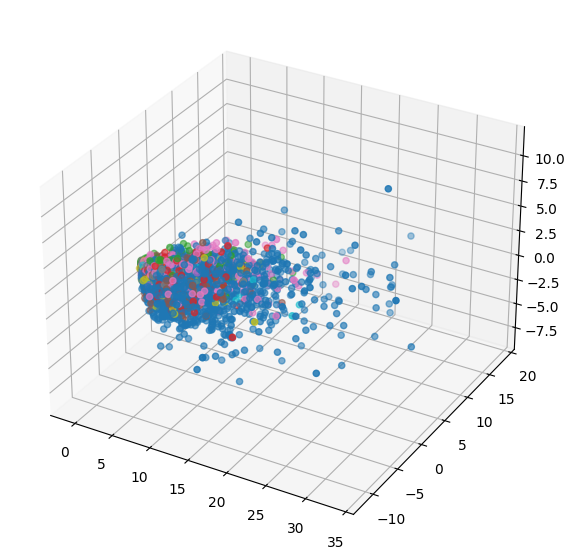

In [20]:
# Perform PCA on the data
pca = PCA(n_components=3)  # Keep all 3 principal components
pca_data = pca.fit_transform(latent_repr_train)  # Shape: (num_samples, 3)

# Define the hue values and create a color map
hue_values = train_labels  # Array of length num_samples with the hue values for each sample
unique_hue_values = np.unique(hue_values)  # Array of unique hue values
num_colors = len(unique_hue_values)  # Number of unique hue values
color_map = ListedColormap(['C{}'.format(i) for i in range(num_colors)])  # Create a color map

# Create a 3D scatter plot using the scatter function from the mplot3d module
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_data[:, 0], pca_data[:, 1], pca_data[:, 2], c=hue_values, cmap=color_map)
plt.show()

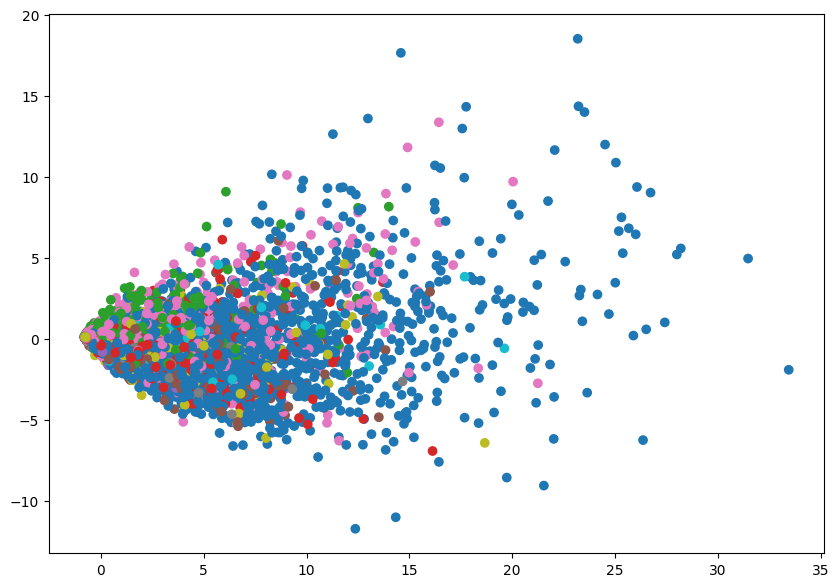

In [21]:
pca = PCA(n_components=2)  # Keep all 3 principal components
pca_data = pca.fit_transform(latent_repr_train)  # Shape: (num_samples, 3)

# Define the hue values and create a color map
hue_values = train_labels  # Array of length num_samples with the hue values for each sample
unique_hue_values = np.unique(hue_values)  # Array of unique hue values
num_colors = len(unique_hue_values)  # Number of unique hue values
color_map = ListedColormap(['C{}'.format(i) for i in range(num_colors)])  # Create a color map

# Create a 3D scatter plot using the scatter function from the mplot3d module
fig = plt.figure(figsize=(10,7))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=hue_values, cmap=color_map)
plt.show()

In [22]:
# Perform PCA on the data
pca = PCA(n_components=2)  # Keep only the first 2 principal components
pca_train = pca.fit_transform(latent_repr_train)  # Shape: (num_train_samples, 2)
pca_test = pca.transform(latent_repr_test)  # Shape: (num_test_samples, 2)

# Define the target values
target_train = train_labels  # Array of length num_train_samples with the target values for the training data
target_test = test_labels  # Array of length num_test_samples with the target values for the test data

# Create the logistic regression model with cross-validation
lr = LogisticRegressionCV(cv=5)

# Train the model on the training data
lr.fit(pca_train, target_train)

# Make predictions on the test data
predictions = lr.predict(pca_test)

# Calculate evaluation metrics for each class
report = classification_report(target_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.61      0.63      0.62       828
           1       0.15      1.00      0.26       944
           2       0.57      0.07      0.12       842
           3       0.22      0.15      0.18       866
           4       0.00      0.00      0.00       805
           5       0.00      0.00      0.00       773
           6       0.29      0.04      0.07       822
           7       0.05      0.02      0.02       919
           8       0.33      0.00      0.00       763
           9       0.00      0.00      0.00       838

    accuracy                           0.20      8400
   macro avg       0.22      0.19      0.13      8400
weighted avg       0.22      0.20      0.13      8400

